<a href="https://colab.research.google.com/github/anirudh-bukka/DiabeticRetinopathy-CapsNet/blob/main/RoutingByAttention_P2_Jan13_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import os
import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.layers import add,concatenate,Multiply,Conv2D,BatchNormalization,Reshape,Input
from keras.layers import Flatten,Dense,Dropout,LeakyReLU,UpSampling2D,ZeroPadding2D,Lambda
from keras.preprocessing import image
from keras.utils import plot_model
from keras.callbacks import *
from keras.utils import to_categorical
from keras.callbacks import TensorBoard
import cv2
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATADIR = "/content/drive/MyDrive/MajorProject/Datasets/Dataset_from_fundus_images_for_the_study_of_diabetic_retinopathy_V02"
CATEGORIES = ["1_No_DR_signs", "2_Mild_NPDR", "3_Moderate_NPDR", "4_Severe_NPDR", "5_Very_Severe_NPDR", "6_PDR", "7_Advanced_PDR"]

In [ ]:
os.chdir(DATADIR)
training_data = []
IMG_SIZE = 128

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

    X = []
    y = []
    for features, label in training_data:
        X.append(features)
        y.append(label)

    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

    return X


# dataset, shape = create_training_data()
dataset = create_training_data()
print('Dataset shape: {0}'.format(dataset.shape))
print(len(training_data))

100%|██████████| 114/114 [00:57<00:00,  1.98it/s]

Dataset shape: (757, 128, 128, 3)
757


In [ ]:
import random
random.shuffle(training_data)
X=[]
y=[]
for features,label in training_data:
    X.append(features)
    y.append(label)
# print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 3))

In [ ]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(to_categorical(y))
X.shape

(757, 128, 128, 3)

In [ ]:
#dividing data to training and splitting
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)
np.save("x_train.npy", x_train)
np.save("y_train.npy", y_train)
np.save("x_test.npy", x_test)
np.save("y_test.npy", y_test)

In [ ]:
#DEFINING SQUASH function
epsilon=1e-7
def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [ ]:
from keras.applications import VGG16, ResNet50, EfficientNetB0,EfficientNetB2, EfficientNetB4

In [ ]:
model = ResNet50(include_top=False, input_shape=(128,128,3))
print(model.summary())

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                      

In [ ]:
layer_name = 'conv2_block3_out'
intermediate_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

In [ ]:
from keras import layers, models
from keras.layers import Dropout
from keras.regularizers import l2

def Routing_with_attention(Layer_L):
    num_capsules = 1
    capsule_dim = 3
    num_routing = 3

    primary_capsules_activation = layers.Conv1D(num_capsules * capsule_dim, kernel_size=1, padding='valid', activation='relu', strides=1)(Layer_L)
    primary_capsules_activation_reshaped = layers.Reshape((-1, num_capsules, capsule_dim))(primary_capsules_activation)

    coupling_coefficients = layers.Dense(num_capsules * num_routing, activation='softmax')(primary_capsules_activation)
    coupling_coefficients_reshaped = layers.Reshape((-1, num_capsules, num_routing))(coupling_coefficients)

    weighted_sum_predicted_vectors = layers.Multiply()([coupling_coefficients_reshaped, primary_capsules_activation_reshaped])
    weighted_sum_predicted_vectors_sum = layers.Lambda(lambda x: K.sum(x, axis=2))(weighted_sum_predicted_vectors)

    output_capsules = layers.Lambda(squash)(weighted_sum_predicted_vectors_sum)

    flattened_output_capsules = layers.Flatten()(output_capsules)
    flattened_output_capsules = layers.Dropout(0.3)(flattened_output_capsules)  # Adjust dropout rate


    # primary_capsules_activation = layers.Conv1D(num_capsules * capsule_dim, kernel_size=1, padding='valid', activation='relu', strides=1)(Layer_L)
    # primary_capsules_activation = BatchNormalization()(primary_capsules_activation)

    dense_layer = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(flattened_output_capsules)
    dense_layer = layers.Dropout(0.3)(dense_layer)

    dense_layer = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dense_layer)
    dense_layer = layers.Dropout(0.3)(dense_layer)

    dense_layer = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dense_layer)
    dense_layer = layers.Dropout(0.3)(dense_layer)

    dense_layer = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dense_layer)
    dense_layer = layers.Dropout(0.3)(dense_layer)


    output_layer = layers.Dense(7, activation='softmax')(flattened_output_capsules)

    return output_layer

In [ ]:
def Encoder(routing):
    In = intermediate_layer_model.input
    convout = intermediate_layer_model.output
    Layer_R = Reshape([-1,2])(convout)
    Layer_L = Lambda(squash)(Layer_R)
    if routing=="Attention":
        Output_Layer= Routing_with_attention(Layer_L)
    return Model(In, Output_Layer)


algo=["Attention"]

In [ ]:
def margin_loss(y_true, y_pred):
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [ ]:
batches=20
epochs=[30]
ensemble_scores={}
scores={}

In [ ]:
# Learning rate schedule
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

# Use Adam optimizer with learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
for j in epochs:
  for k in algo:
    print("{1} algorithm for {0} epochs".format(j,k))
    capsnet = Encoder(k)
    #print(capsnet.summary())
    discriminator = capsnet
    #print('DISCRIMINATOR:')
    #discriminator.summary()
    #decay_rate = learning_rate /num_epoch
    momentum = 0.90
    #opt= SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    opt =tf.keras.optimizers.Adam(learning_rate=0.0001)
    discriminator.compile(loss=[margin_loss, 'mse'],
                          optimizer= opt, # optimizer,
                          metrics=['accuracy']) # metrics=[keras.metrics.Precision(), keras.metrics.Recall()])
    model=discriminator
    history=model.fit(x_train, y_train, batch_size=batches, epochs=j, validation_data=(x_test, y_test))
    # evaluate the model
    _, train_acc = model.evaluate(x_train, y_train, verbose=0)
    _, test_acc = model.evaluate(x_test, y_test, verbose=0)

    os.chdir("/content/drive/MyDrive/MajorProject/h5_models")
    model.save("{0}_{1}epochs_CT.h5".format(k,j))

Attention algorithm for 30 epochs
Epoch 1/30
31/31 [==============================] - 16s 120ms/step - loss: 0.5091 - accuracy: 0.3653 - val_loss: 0.5191 - val_accuracy: 0.3684
Epoch 2/30
31/31 [==============================] - 2s 73ms/step - loss: 0.4444 - accuracy: 0.4397 - val_loss: 0.4782 - val_accuracy: 0.3816
Epoch 3/30
31/31 [==============================] - 2s 78ms/step - loss: 0.3852 - accuracy: 0.5289 - val_loss: 0.4409 - val_accuracy: 0.4408
Epoch 4/30
31/31 [==============================] - 2s 72ms/step - loss: 0.3259 - accuracy: 0.6314 - val_loss: 0.4377 - val_accuracy: 0.4737
Epoch 5/30
31/31 [==============================] - 2s 71ms/step - loss: 0.2855 - accuracy: 0.6992 - val_loss: 0.3775 - val_accuracy: 0.4868
Epoch 6/30
31/31 [==============================] - 2s 72ms/step - loss: 0.2486 - accuracy: 0.7521 - val_loss: 0.3464 - val_accuracy: 0.6250
Epoch 7/30
31/31 [==============================] - 2s 71ms/step - loss: 0.2028 - accuracy: 0.8066 - val_loss: 0.3496 

In [ ]:
# Function to plot the classification report as a table
def plot_classification_report(report, ep,alg,title='Classification Report', cmap='viridis'):
    lines = report.split('\n')
    classes = []
    plotMat = []
    for line in lines[2:(len(lines)-5)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1:len(t)-1]]
        plotMat.append(v)
    plotMat = np.array(plotMat)
    fig, ax = plt.subplots(1, 1)
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=plotMat, colLabels=['precision', 'recall', 'f1-score', 'support'], rowLabels=classes, loc='center', cellLoc = 'center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10)
    the_table.scale(1.2, 1.2)
    plt.title('classification_report for {0} epochs for {1} algorithm'.format(ep,alg))
    plt.savefig('classification_report for {0} epochs for {1} algorithm'.format(ep,alg)+".png", dpi=300)
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [ ]:
from keras.models import load_model
custom_objects = {'margin_loss': margin_loss}
#### loaded_model = load_model("/content/drive/MyDrive/Major Project Final/CT scan/{0}_{1}epochs_CT.h5".format(k,j), custom_objects=custom_objects)
loaded_model = load_model("/content/drive/MyDrive/MajorProject/h5_models/{0}_{1}epochs_CT.h5".format(k,j), custom_objects=custom_objects)
#loaded_model.summary()

pred1 = loaded_model.predict(x_test)
pred_labels = np.argmax(pred1, axis=1)
test_labels = np.argmax(y_test, axis=1)
train_labels = np.argmax(y_train,axis=1)

report= classification_report(test_labels,pred_labels)

#### os.chdir('/content/drive/MyDrive/Major Project Final/CT scan Results')
os.chdir('/content/drive/MyDrive/MajorProject/Results')
print("Classification Report for {0} Algorithm for {1} DR\n: ".format(k,j),report)

5/5 [==============================] - 1s 48ms/step
Classification Report for Attention Algorithm for 30 DR
:                precision    recall  f1-score   support

           0       0.61      0.87      0.72        31
           1       0.00      0.00      0.00         1
           2       0.64      0.39      0.48        18
           3       0.70      0.94      0.80        34
           4       0.67      0.64      0.65        22
           5       0.43      0.25      0.32        24
           6       0.94      0.68      0.79        22

    accuracy                           0.66       152
   macro avg       0.57      0.54      0.54       152
weighted avg       0.66      0.66      0.64       152



In [ ]:
!pip install tensorflow_model_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Define the sparsity (percentage of weights to be pruned)
pruning_params = {
    'pruning_schedule': pruning_schedule.ConstantSparsity(0.5, begin_step=0, frequency=75) # frequency = 100
}

pruned_model = prune.prune_low_magnitude(model, **pruning_params) # Sir here we are pruning the model

pruned_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-5),
    metrics=['accuracy']
)

print(pruned_model.summary())

finetune_epochs = 30

# Add the UpdatePruningStep callback during training
callbacks = [
    pruning_callbacks.UpdatePruningStep()
] # WHY THIS IS IMPORTANT, EXPLAIN

# Fine-tune the pruned model
pruned_history = pruned_model.fit(
    x_train,
    y_train,
    batch_size=batches,
    epochs=finetune_epochs,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)

# Evaluate the pruned model
test_loss, test_accuracy = pruned_model.evaluate(x_test, y_test)

# Save the pruned model
os.chdir("/content/drive/MyDrive/MajorProject/h5_models")
pruned_model.save("Pruned_Model_0.h5")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 prune_low_magnitude_conv1_  (None, 134, 134, 3)          1         ['input_1[0][0]']             
 pad (PruneLowMagnitude)                                                                          
                                                                                                  
 prune_low_magnitude_conv1_  (None, 64, 64, 64)           18882     ['prune_low_magnitude_conv1_pa
 conv (PruneLowMagnitude)                                           d[0][0]']                     
                                                                                            

In [ ]:
#################################################################################################################################################

In [ ]:
!pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.6 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

num_classes = 7
num_folds = 5

y_labels = np.argmax(y, axis=1) # Converting multilabel targets to single-label format (using argmax)

# stratified k-fold cross-validation
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# These are the lists to store results
all_train_acc = []
all_val_acc = []

for train_index, val_index in kf.split(X, y_labels): #  iterating over each fold

    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model.fit(x_train, y_train, epochs=10, batch_size=20, verbose=0)    #  training the model on the training set
    val_preds = model.predict(x_val)

    train_preds = model.predict(x_train) # evaluating the model on the training set
    train_acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_preds, axis=1))
    all_train_acc.append(train_acc)

    val_preds = model.predict(x_val) # evaluating the model on the validation set
    val_acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_preds, axis=1))
    all_val_acc.append(val_acc)

avg_train_acc = np.mean(all_train_acc)
avg_val_acc = np.mean(all_val_acc)
print(f'Training Accuracy: {avg_train_acc:.4f}')
print(f'Validation Accuracy: {avg_val_acc:.4f}')


5/5 [==============================] - 0s 31ms/step
Training Accuracy: 0.9828
Validation Accuracy: 0.9499


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Lists to store results
all_train_preds = []
all_val_preds = []
all_train_labels = []
all_val_labels = []

for train_index, val_index in kf.split(X, y_labels): # iterating over each fold

    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    pruned_model.fit(x_train, y_train, epochs=10, batch_size=20, verbose=0) # training the model on the training set

    train_preds = pruned_model.predict(x_train) # evaluating the model on the training set
    all_train_preds.append(train_preds)
    all_train_labels.append(y_train)

    val_preds = pruned_model.predict(x_val) # evaluating the model on the validation set
    all_val_preds.append(val_preds)
    all_val_labels.append(y_val)

avg_train_preds = np.concatenate(all_train_preds)
avg_train_labels = np.concatenate(all_train_labels)
avg_val_preds = np.concatenate(all_val_preds)
avg_val_labels = np.concatenate(all_val_labels)

# Convert predictions and labels to argmax format
train_preds_argmax = np.argmax(avg_train_preds, axis=1)
val_preds_argmax = np.argmax(avg_val_preds, axis=1)
train_labels_argmax = np.argmax(avg_train_labels, axis=1)
val_labels_argmax = np.argmax(avg_val_labels, axis=1)

# Use OneHotEncoder to convert the argmax format to one-hot encoded format
encoder = OneHotEncoder(sparse=False, categories='auto')
encoder.fit(train_labels_argmax.reshape(-1, 1))  # Fit the encoder on training labels

# Transform predictions to one-hot encoded format
train_preds_onehot = encoder.transform(train_preds_argmax.reshape(-1, 1))
val_preds_onehot = encoder.transform(val_preds_argmax.reshape(-1, 1))


5/5 [==============================] - 0s 31ms/step


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

num_classes = 7
num_folds = 5

y_labels = np.argmax(y, axis=1)  # Converting multilabel targets to single-label format (using argmax)

kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []
all_train_precision = []
all_val_precision = []
all_train_recall = []
all_val_recall = []
all_train_f1 = []
all_val_f1 = []
all_train_auc = []
all_val_auc = []

# Define lists to store the metrics for each fold
all_train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
all_val_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}


for i, (train_index, val_index) in enumerate(kf.split(X, y_labels), 1):
    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    pruned_model_history = pruned_model.fit(x_train, y_train, epochs=30, batch_size=20, verbose=0,
                                           validation_data=(x_val, y_val))

    # Store training and validation accuracy for each fold
    all_train_acc.append(pruned_model_history.history['accuracy'])
    all_val_acc.append(pruned_model_history.history['val_accuracy'])

    # Store training and validation loss for each fold
    all_train_loss.append(pruned_model_history.history['loss'])
    all_val_loss.append(pruned_model_history.history['val_loss'])

    # Calculate one-hot encoded predictions
    train_preds = pruned_model.predict(x_train)
    val_preds = pruned_model.predict(x_val)

    # Convert labels to one-hot encoding
    y_train_bin = label_binarize(y_train.argmax(axis=1), classes=range(num_classes))
    y_val_bin = label_binarize(y_val.argmax(axis=1), classes=range(num_classes))

    # Calculate precision, recall, f1, and auc for each class
    train_precision = [precision_score(y_train_bin[:, j], (train_preds[:, j] > 0.5).astype(int)) for j in range(num_classes)]
    val_precision = [precision_score(y_val_bin[:, j], (val_preds[:, j] > 0.5).astype(int)) for j in range(num_classes)]

    train_recall = [recall_score(y_train_bin[:, j], (train_preds[:, j] > 0.5).astype(int)) for j in range(num_classes)]
    val_recall = [recall_score(y_val_bin[:, j], (val_preds[:, j] > 0.5).astype(int)) for j in range(num_classes)]

    train_f1 = [f1_score(y_train_bin[:, j], (train_preds[:, j] > 0.5).astype(int)) for j in range(num_classes)]
    val_f1 = [f1_score(y_val_bin[:, j], (val_preds[:, j] > 0.5).astype(int)) for j in range(num_classes)]

    train_auc = [roc_auc_score(y_train_bin[:, j], train_preds[:, j]) for j in range(num_classes)]
    val_auc = [roc_auc_score(y_val_bin[:, j], val_preds[:, j]) for j in range(num_classes)]

    # Store precision, recall, f1, and auc for each fold
    all_train_precision.append(train_precision)
    all_val_precision.append(val_precision)
    all_train_recall.append(train_recall)
    all_val_recall.append(val_recall)
    all_train_f1.append(train_f1)
    all_val_f1.append(val_f1)
    all_train_auc.append(train_auc)
    all_val_auc.append(val_auc)

    # Print metrics for each fold
    print(f'\nFold {i} Metrics:')
    print(f'Training Accuracy: {train_acc:.4f}')
    print(f'Validation Accuracy: {val_acc:.4f}')

    for j in range(num_classes):
        print(f'\nClass {j+1} Metrics:')
        print(f'Training Precision: {train_precision[j]:.4f}')
        print(f'Validation Precision: {val_precision[j]:.4f}')

        print(f'Training Recall: {train_recall[j]:.4f}')
        print(f'Validation Recall: {val_recall[j]:.4f}')

        print(f'Training F1-Score: {train_f1[j]:.4f}')
        print(f'Validation F1-Score: {val_f1[j]:.4f}')

        print(f'Training AUC: {train_auc[j]:.4f}')
        print(f'Validation AUC: {val_auc[j]:.4f}')

    # Append metrics for each fold
    all_train_metrics['accuracy'].append(train_acc)
    all_val_metrics['accuracy'].append(val_acc)

    all_train_metrics['precision'].append(train_precision)
    all_val_metrics['precision'].append(val_precision)

    all_train_metrics['recall'].append(train_recall)
    all_val_metrics['recall'].append(val_recall)

    all_train_metrics['f1'].append(train_f1)
    all_val_metrics['f1'].append(val_f1)

    all_train_metrics['auc'].append(train_auc)
    all_val_metrics['auc'].append(val_auc)


avg_train_acc = np.mean(all_train_acc)
avg_val_acc = np.mean(all_val_acc)
print(f'Training Accuracy: {avg_train_acc:.4f}')
print(f'Validation Accuracy: {avg_val_acc:.4f}')

os.chdir("/content/drive/MyDrive/MajorProject/h5_models")
pruned_model.save("Pruned_Model.h5")

# Calculate and print mean and standard deviation for each metric
print('\nOverall Metrics:')
print('------------------------')
print(f'Training Accuracy - Mean: {np.mean(all_train_metrics["accuracy"]):.4f}, Std: {np.std(all_train_metrics["accuracy"]):.4f}')
print(f'Validation Accuracy - Mean: {np.mean(all_val_metrics["accuracy"]):.4f}, Std: {np.std(all_val_metrics["accuracy"]):.4f}')

for metric in ['precision', 'recall', 'f1', 'auc']:
    print(f'\n{metric.capitalize()} - Mean and Std for Each Class:')
    print('----------------------------------------')
    for j in range(num_classes):
        train_metric_values = [fold[j] for fold in all_train_metrics[metric]]
        val_metric_values = [fold[j] for fold in all_val_metrics[metric]]

        print(f'Class {j+1} - Training: Mean: {np.mean(train_metric_values):.4f}, Std: {np.std(train_metric_values):.4f}')
        print(f'Class {j+1} - Validation: Mean: {np.mean(val_metric_values):.4f}, Std: {np.std(val_metric_values):.4f}')


#     # Print metrics for each fold
#     print(f"\nFold {i} Metrics:")
#     print(f"Training Accuracy: {pruned_model_history.history['accuracy'][-1]:.4f}")
#     print(f"Validation Accuracy: {pruned_model_history.history['val_accuracy'][-1]:.4f}")

#     for j in range(num_classes):
#         print(f"\nClass {j + 1} Metrics:")
#         print(f"Training Precision: {train_precision[j]:.4f}")
#         print(f"Validation Precision: {val_precision[j]:.4f}")

#         print(f"Training Recall: {train_recall[j]:.4f}")
#         print(f"Validation Recall: {val_recall[j]:.4f}")

#         print(f"Training F1-Score: {train_f1[j]:.4f}")
#         print(f"Validation F1-Score: {val_f1[j]:.4f}")

#         print(f"Training AUC: {train_auc[j]:.4f}")
#         print(f"Validation AUC: {val_auc[j]:.4f}")

# # Now you can access the metrics for each fold using the lists like all_train_acc, all_val_acc, all_train_precision, etc.


5/5 [==============================] - 0s 32ms/step

Fold 1 Metrics:
Training Accuracy: 0.9868
Validation Accuracy: 0.9603

Class 1 Metrics:
Training Precision: 0.9934
Validation Precision: 1.0000
Training Recall: 1.0000
Validation Recall: 0.9730
Training F1-Score: 0.9967
Validation F1-Score: 0.9863
Training AUC: 1.0000
Validation AUC: 1.0000

Class 2 Metrics:
Training Precision: 1.0000
Validation Precision: 1.0000
Training Recall: 0.7500
Validation Recall: 1.0000
Training F1-Score: 0.8571
Validation F1-Score: 1.0000
Training AUC: 0.9998
Validation AUC: 1.0000

Class 3 Metrics:
Training Precision: 0.9683
Validation Precision: 1.0000
Training Recall: 0.9683
Validation Recall: 0.8750
Training F1-Score: 0.9683
Validation F1-Score: 0.9333
Training AUC: 0.9998
Validation AUC: 1.0000

Class 4 Metrics:
Training Precision: 0.9929
Validation Precision: 1.0000
Training Recall: 0.9929
Validation Recall: 1.0000
Training F1-Score: 0.9929
Validation F1-Score: 1.0000
Training AUC: 0.9999
Validation A

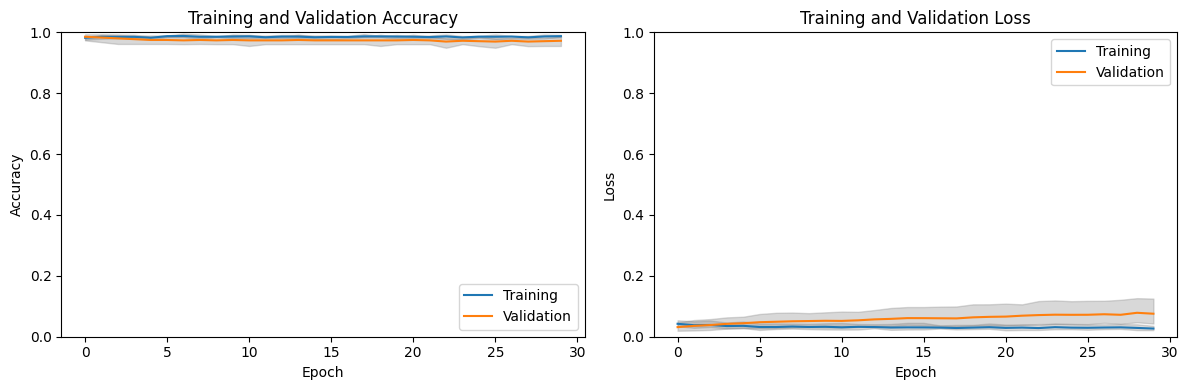

Average Training Accuracy: 0.9875
Average Validation Accuracy: 0.9723


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the following lists:
# all_train_acc, all_val_acc, all_train_loss, all_val_loss

# Calculate mean and confidence intervals
mean_train_acc = np.mean(all_train_acc, axis=0)
mean_val_acc = np.mean(all_val_acc, axis=0)
ci_upper_train_acc = np.percentile(all_train_acc, 97.5, axis=0)
ci_lower_train_acc = np.percentile(all_train_acc, 2.5, axis=0)
ci_upper_val_acc = np.percentile(all_val_acc, 97.5, axis=0)
ci_lower_val_acc = np.percentile(all_val_acc, 2.5, axis=0)

mean_train_loss = np.mean(all_train_loss, axis=0)
mean_val_loss = np.mean(all_val_loss, axis=0)
ci_upper_train_loss = np.percentile(all_train_loss, 97.5, axis=0)
ci_lower_train_loss = np.percentile(all_train_loss, 2.5, axis=0)
ci_upper_val_loss = np.percentile(all_val_loss, 97.5, axis=0)
ci_lower_val_loss = np.percentile(all_val_loss, 2.5, axis=0)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mean_train_acc, label='Training')
plt.plot(mean_val_acc, label='Validation')
plt.fill_between(range(len(mean_train_acc)), ci_lower_train_acc, ci_upper_train_acc, color='grey', alpha=0.3)
plt.fill_between(range(len(mean_val_acc)), ci_lower_val_acc, ci_upper_val_acc, color='grey', alpha=0.3)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc = 'lower right')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(mean_train_loss, label='Training')
plt.plot(mean_val_loss, label='Validation')
plt.fill_between(range(len(mean_train_loss)), ci_lower_train_loss, ci_upper_train_loss, color='grey', alpha=0.3)
plt.fill_between(range(len(mean_val_loss)), ci_lower_val_loss, ci_upper_val_loss, color='grey', alpha=0.3)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend(loc = 'best')

plt.tight_layout()
plt.show()

avg_train_acc = np.mean([fold[-1] for fold in all_train_acc])
avg_val_acc = np.mean([fold[-1] for fold in all_val_acc])
print(f'Average Training Accuracy: {avg_train_acc:.4f}')
print(f'Average Validation Accuracy: {avg_val_acc:.4f}')


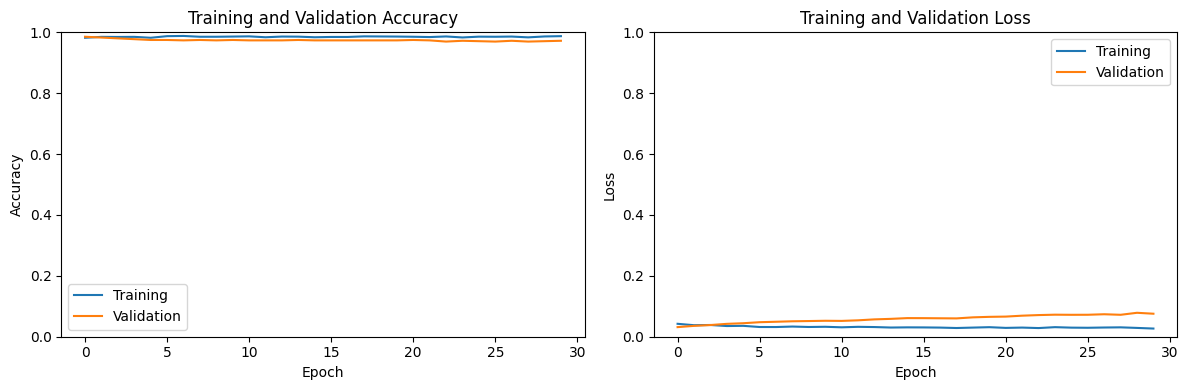

Average Training Accuracy: 0.9875
Average Validation Accuracy: 0.9723


In [ ]:
# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.mean(all_train_acc, axis=0), label='Training')
plt.plot(np.mean(all_val_acc, axis=0), label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(np.mean(all_train_loss, axis=0), label='Training')
plt.plot(np.mean(all_val_loss, axis=0), label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

avg_train_acc = np.mean([fold[-1] for fold in all_train_acc])
avg_val_acc = np.mean([fold[-1] for fold in all_val_acc])
print(f'Average Training Accuracy: {avg_train_acc:.4f}')
print(f'Average Validation Accuracy: {avg_val_acc:.4f}')

5/5 [==============================] - 0s 31ms/step


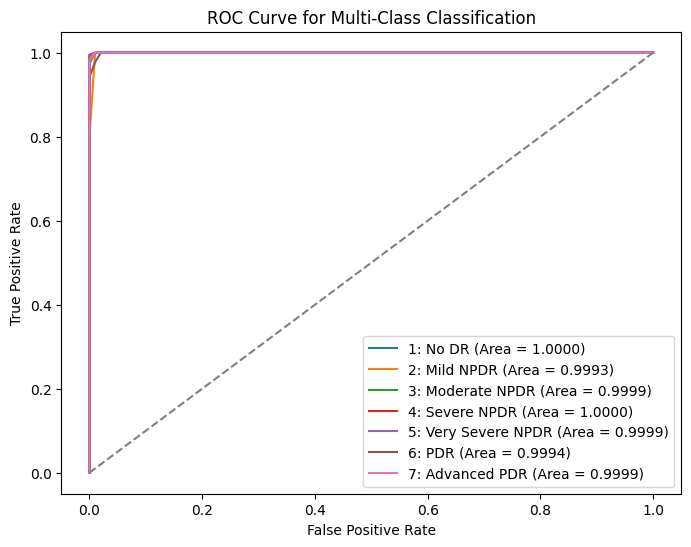

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

all_class_fpr = []
all_class_tpr = []
all_class_auc = []

# Plotting ROC curve for each fold
plt.figure(figsize=(8, 6))
for i, (train_index, val_index) in enumerate(kf.split(X, y_labels)):
    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # pruned_model_history = model.fit(x_train, y_train, epochs=30, batch_size=20, verbose=0,
    #                                  validation_data=(x_val, y_val))  # training the model on the training set

    val_preds = pruned_model.predict(x_val)

    # Calculate ROC curve for each class
    class_fpr = dict()
    class_tpr = dict()
    class_auc = dict()

    for j in range(num_classes):
        class_fpr[j], class_tpr[j], _ = roc_curve(y_val[:, j], val_preds[:, j])
        class_auc[j] = auc(class_fpr[j], class_tpr[j])

    # Append results for each class to the lists created above
    all_class_fpr.append(class_fpr)
    all_class_tpr.append(class_tpr)
    all_class_auc.append(class_auc)

class_names = ["1: No DR", "2: Mild NPDR", "3: Moderate NPDR", "4: Severe NPDR", "5: Very Severe NPDR", "6: PDR", "7: Advanced PDR"]

for j in range(num_classes): # ROC curve over all folds for each class
    mean_class_fpr = np.linspace(0, 1, 100)
    mean_class_tpr = np.mean([np.interp(mean_class_fpr, fpr[j], tpr[j]) for fpr, tpr in zip(all_class_fpr, all_class_tpr)], axis=0)
    mean_class_auc = np.mean([auc(fpr[j], tpr[j]) for fpr, tpr in zip(all_class_fpr, all_class_tpr)])

    mean_class_fpr = np.concatenate([[0.0], mean_class_fpr]) # Not necessary, just to ensure the ROC curve starts from (0,0)
    mean_class_tpr = np.concatenate([[0.0], mean_class_tpr])

    plt.plot(mean_class_fpr, mean_class_tpr, label=f'{class_names[j]} (Area = {mean_class_auc:.4f})')

# Plotting
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Lists to store true labels and predicted labels
all_true_labels = []
all_pred_labels = []

# Plotting ROC curve for each fold
plt.figure(figsize=(8, 6))
for i, (train_index, val_index) in enumerate(kf.split(X, y_labels)):
    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # pruned_model_history = pruned_model.fit(x_train, y_train, epochs=30, batch_size=20, verbose=0, validation_data=(x_val, y_val))  # training the model on the training set

    # Evaluate the model on the validation set
    val_preds = pruned_model.predict(x_val)

    # Store true and predicted labels for each fold
    all_true_labels.append(y_val)
    all_pred_labels.append(val_preds)


5/5 [==============================] - 0s 31ms/step


<Figure size 800x600 with 0 Axes>

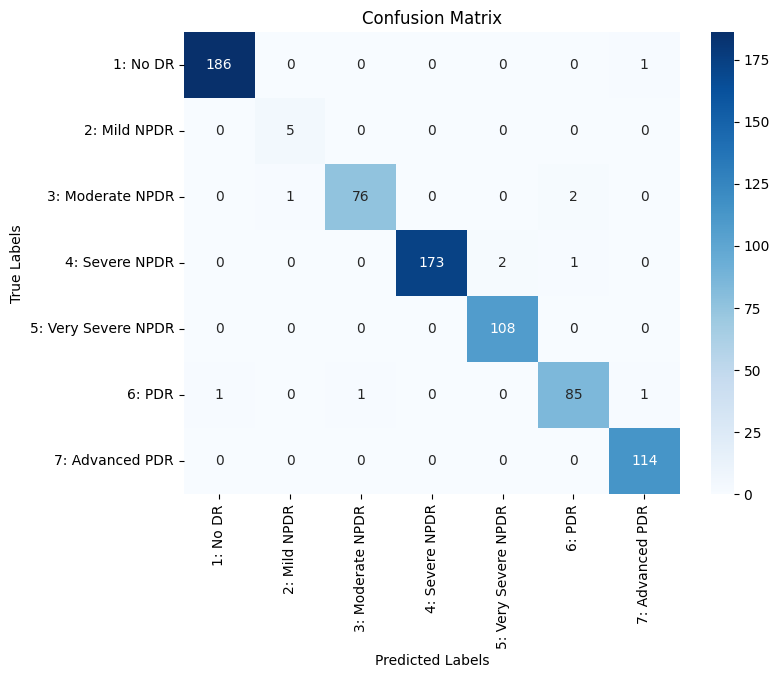

Classification Report:
                     precision    recall  f1-score   support

           1: No DR       0.99      0.99      0.99       187
       2: Mild NPDR       0.83      1.00      0.91         5
   3: Moderate NPDR       0.99      0.96      0.97        79
     4: Severe NPDR       1.00      0.98      0.99       176
5: Very Severe NPDR       0.98      1.00      0.99       108
             6: PDR       0.97      0.97      0.97        88
    7: Advanced PDR       0.98      1.00      0.99       114

           accuracy                           0.99       757
          macro avg       0.96      0.99      0.97       757
       weighted avg       0.99      0.99      0.99       757



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Concatenate true and predicted labels for all folds
all_true_labels = np.concatenate(all_true_labels)
all_pred_labels = np.concatenate(all_pred_labels)

# Convert probabilities to class labels
predicted_classes = np.argmax(all_pred_labels, axis=1)
true_classes = np.argmax(all_true_labels, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
# print("Confusion Matrix:")
# print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
class_report = classification_report(true_classes, predicted_classes, target_names=class_names)
print("Classification Report:")
print(class_report)

In [ ]:
# Install required libraries
# !pip install ipywidgets

# Import necessary libraries
from ipywidgets import FileUpload, Image
import io
from PIL import Image as PILImage
import numpy as np

# Define the function to perform classification
def classify_image(img):
    # Preprocess the image
    img = img.resize((128, 128))  # Resize image to match model input size
    img = np.array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Perform classification using CapsNet model
    predictions = pruned_model.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_class = CATEGORIES[predicted_class_index]

    return predicted_class

# Define a function to handle file upload
def handle_upload(change):
    img = PILImage.open(io.BytesIO(upload_button.data[-1]))
    predicted_class = classify_image(img)
    display(img)
    print('Predicted Diabetic Retinopathy Stage:', predicted_class)

# Create a file uploader widget
upload_button = FileUpload(accept='image/*', multiple=False)
upload_button.observe(handle_upload, names='_counter')
display(upload_button)


FileUpload(value={}, accept='image/*', description='Upload')

1/1 [==============================] - 1s 680ms/step


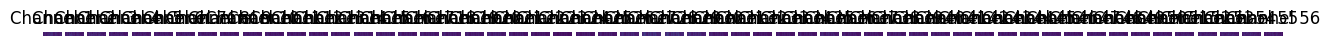

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50

# Load the pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

# Define a function to visualize the intermediate layer outputs
def visualize_intermediate_layers(model, img_path, layer_name):
    # Load the image and preprocess it
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Define a new model that outputs the activations of the specified layer
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)

    # Get the intermediate layer activations for the input image
    intermediate_output = intermediate_layer_model.predict(x)

    # Visualize the activations
    fig, axes = plt.subplots(1, len(intermediate_output[0]), figsize=(16, 4))
    for i, activation_map in enumerate(intermediate_output[0]):
        axes[i].imshow(activation_map)
        axes[i].axis('off')
        axes[i].set_title(f'Channel {i+1}')
    plt.show()

# Specify the path to the input image
img_path = '/content/drive/MyDrive/MajorProject/Datasets/Dataset_from_fundus_images_for_the_study_of_diabetic_retinopathy_V02/4_Severe_NPDR/291.jpg'

# Specify the layer name for which you want to visualize the activations
layer_name = 'conv2_block3_out'  # Example layer name, change it according to your model

# Visualize the intermediate layer activations
visualize_intermediate_layers(model, img_path, layer_name)


1/1 [==============================] - 0s 469ms/step


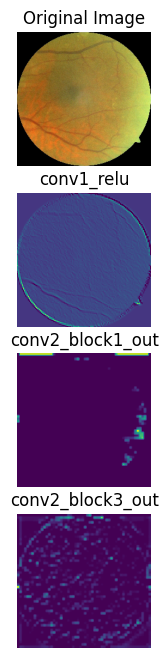

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import Model

def plot_conv_layer_output(model, img_path, layer_names):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Create a new model that outputs intermediate activations
    intermediate_layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=intermediate_layer_outputs)

    # Get the intermediate activations for the input image
    activations = activation_model.predict(img_array)

    # Plot the original image
    plt.figure(figsize=(8, 8))
    plt.subplot(len(layer_names) + 1, 1, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Plot the intermediate activations for each convolutional layer
    for i, activation in enumerate(activations):
        plt.subplot(len(layer_names) + 1, 1, i + 2)
        plt.imshow(activation[0, :, :, 0], cmap='viridis')  # Assuming the output of the layer is 4-dimensional
        plt.title(layer_names[i])
        plt.axis('off')

    plt.show()

# Load your model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

# Specify the layer names whose output you want to visualize
layer_names = ['conv1_relu', 'conv2_block1_out', 'conv2_block3_out']  # Add more layer names as needed

# Path to the input image
img_path = '/content/drive/MyDrive/MajorProject/Datasets/Dataset_from_fundus_images_for_the_study_of_diabetic_retinopathy_V02/4_Severe_NPDR/291.jpg'

# Plot the original image and its processed image at each convolutional layer's output
plot_conv_layer_output(model, img_path, layer_names)


1/1 [==============================] - 0s 370ms/step


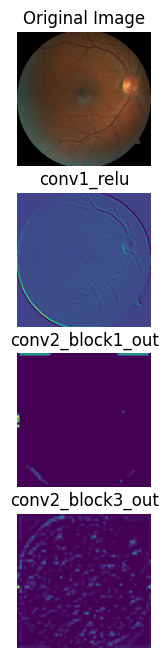

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import Model

def plot_conv_layer_output(model, img_path, layer_names):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Create a new model that outputs intermediate activations
    intermediate_layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=intermediate_layer_outputs)

    # Get the intermediate activations for the input image
    activations = activation_model.predict(img_array)

    # Plot the original image
    plt.figure(figsize=(8, 8))
    plt.subplot(len(layer_names) + 1, 1, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Plot the intermediate activations for each convolutional layer
    for i, activation in enumerate(activations):
        plt.subplot(len(layer_names) + 1, 1, i + 2)
        plt.imshow(activation[0, :, :, 0], cmap='viridis')  # Assuming the output of the layer is 4-dimensional
        plt.title(layer_names[i])
        plt.axis('off')

    plt.show()

# Load your model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

# Specify the layer names whose output you want to visualize
layer_names = ['conv1_relu', 'conv2_block1_out', 'conv2_block3_out']  # Add more layer names as needed

# Path to the input image
img_path = '/content/drive/MyDrive/MajorProject/Datasets/Dataset_from_fundus_images_for_the_study_of_diabetic_retinopathy_V02/2_Mild_NPDR/191.jpg'

# Plot the original image and its processed image at each convolutional layer's output
plot_conv_layer_output(model, img_path, layer_names)


1/1 [==============================] - 1s 524ms/step


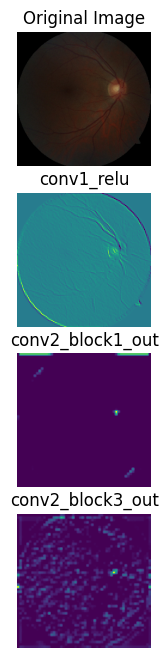

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import Model

def plot_conv_layer_output(model, img_path, layer_names):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Create a new model that outputs intermediate activations
    intermediate_layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=intermediate_layer_outputs)

    # Get the intermediate activations for the input image
    activations = activation_model.predict(img_array)

    # Plot the original image
    plt.figure(figsize=(8, 8))
    plt.subplot(len(layer_names) + 1, 1, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Plot the intermediate activations for each convolutional layer
    for i, activation in enumerate(activations):
        plt.subplot(len(layer_names) + 1, 1, i + 2)
        plt.imshow(activation[0, :, :, 0], cmap='viridis')  # Assuming the output of the layer is 4-dimensional
        plt.title(layer_names[i])
        plt.axis('off')

    plt.show()

# Load your model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

# Specify the layer names whose output you want to visualize
layer_names = ['conv1_relu', 'conv2_block1_out', 'conv2_block3_out']  # Add more layer names as needed

# Path to the input image
img_path = '/content/drive/MyDrive/MajorProject/Datasets/Dataset_from_fundus_images_for_the_study_of_diabetic_retinopathy_V02/1_No_DR_signs/121.jpg'

# Plot the original image and its processed image at each convolutional layer's output
plot_conv_layer_output(model, img_path, layer_names)


1/1 [==============================] - 1s 548ms/step


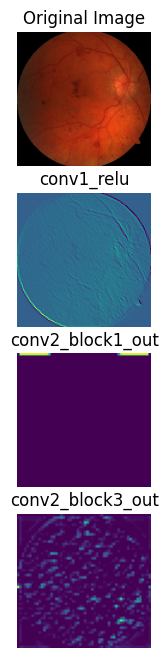

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import Model

def plot_conv_layer_output(model, img_path, layer_names):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Create a new model that outputs intermediate activations
    intermediate_layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=intermediate_layer_outputs)

    # Get the intermediate activations for the input image
    activations = activation_model.predict(img_array)

    # Plot the original image
    plt.figure(figsize=(8, 8))
    plt.subplot(len(layer_names) + 1, 1, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Plot the intermediate activations for each convolutional layer
    for i, activation in enumerate(activations):
        plt.subplot(len(layer_names) + 1, 1, i + 2)
        plt.imshow(activation[0, :, :, 0], cmap='viridis')  # Assuming the output of the layer is 4-dimensional
        plt.title(layer_names[i])
        plt.axis('off')

    plt.show()

# Load your model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

# Specify the layer names whose output you want to visualize
layer_names = ['conv1_relu', 'conv2_block1_out', 'conv2_block3_out']  # Add more layer names as needed

# Path to the input image
img_path = '/content/drive/MyDrive/MajorProject/Datasets/Dataset_from_fundus_images_for_the_study_of_diabetic_retinopathy_V02/6_PDR/574.jpg'

# Plot the original image and its processed image at each convolutional layer's output
plot_conv_layer_output(model, img_path, layer_names)
